# Stock Price Prediction on BURSA

## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from pathlib import Path

## Import dataset

In [2]:
df = pd.read_csv(Path("BURSA5.csv"), index_col="Date", 
                    infer_datetime_format=True, parse_dates=True)

df = df.drop(['Adj Close'], axis=1)
training_set = df.iloc[:, 1:2].values
df.head()

C:\Users\irwin\AppData\Local\Temp\ipykernel_37344\3209652023.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(Path("BURSA5.csv"), index_col="Date",


,Open,High,Low,Close,Volume
Date,,,,,
2018-01-02,6.800000,6.800000,6.680000,6.746666,1412850
2018-01-03,6.746666,6.946666,6.746666,6.933333,7190550
2018-01-04,6.946666,7.013333,6.946666,7.013333,5788500
2018-01-05,7.013333,7.173333,7.013333,7.093333,1145250
2018-01-08,7.120000,7.200000,7.120000,7.173333,2522550


The 'Adj Close' column is dropped because the adjusted close price values will be more complicated to calculate as it is the closing price after adjustments for all applicable splits and dividend distributions. The other values like 'Open', 'High', 'Low', 'Close' do not contain any adjustments. 

In [3]:
#print the shape of dataframe and check for NULL values
print("Dataframe Shape: ", df.shape)
print("Null Value Present: ", df.isnull().values.any())

Dataframe Shape:  (1225, 5)
Null Value Present:  False


## Data Preprocessing

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

features = ['Open', 'High', 'Low', 'Close', 'Volume']
X = df[features]
y = df['Close']

# Define the TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=4)

# Original dataset normalisation
for train_index, test_index in tscv.split(X):
    scaler = MinMaxScaler()
    df_transformed = scaler.fit_transform(X)

    df_transformed = pd.DataFrame(columns=features, data=df_transformed, index=X.index)


# Iterate over each split and fit the scaler on the training set and transform it
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    scaler = MinMaxScaler()
    X_train_transformed = scaler.fit_transform(X_train)
    X_test_transformed = scaler.transform(X_test)
    y_train_transformed = scaler.fit_transform(y_train.values.reshape(-1,1))
    y_test_transformed = scaler.transform(y_test.values.reshape(-1,1))

# Convert the transformed training set and test set back to dataframes
    X_train_transformed = pd.DataFrame(columns=features, data=X_train_transformed, index=X_train.index)
    X_test_transformed = pd.DataFrame(columns=features, data=X_test_transformed, index=X_test.index)
    y_train_transformed = pd.DataFrame(columns=['Close'], data=y_train_transformed, index=y_train.index)
    y_test_transformed = pd.DataFrame(columns=['Close'], data=y_test_transformed, index=y_test.index)

X_train_transformed.head()

,Open,High,Low,Close,Volume
Date,,,,,
2018-01-02,0.375000,0.342767,0.394649,0.376483,0.073271
2018-01-03,0.366667,0.365828,0.405797,0.406688,0.372907
2018-01-04,0.397917,0.376310,0.439242,0.419633,0.300196
2018-01-05,0.408333,0.401467,0.450390,0.432578,0.059394
2018-01-08,0.425000,0.405660,0.468227,0.445523,0.130821


## Analysis

### Correlation Strength Analysis

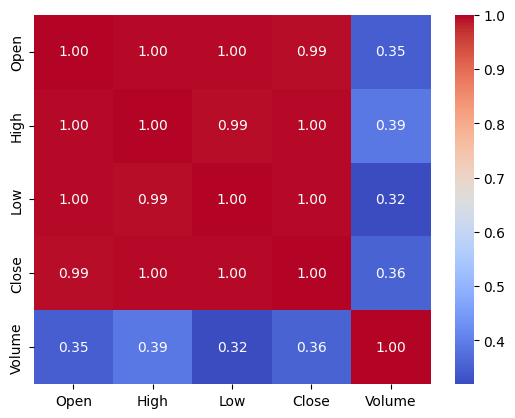

The important features are: ['Open', 'High', 'Low', 'Close']


In [5]:
# checking the correlation between the variables with 3 different methods
import pandas as pd
import seaborn as sns

# Calculate the correlation matrix
corr_matrix = X_train_transformed.corr()

# Plot the heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')
plt.show()

# Select the most important features
important_features = corr_matrix['Close'][abs(corr_matrix['Close']) > 0.5].index.tolist()

print('The important features are:', important_features)

### Feature Importance Scores

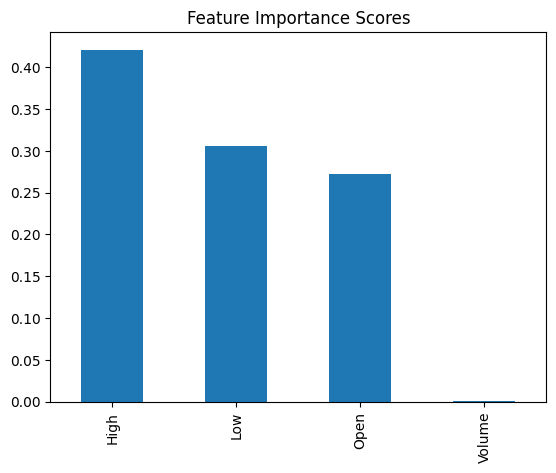

High      0.420853
Low       0.305792
Open      0.272371
Volume    0.000984
dtype: float64


In [6]:
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor

# Separate features and target variable
X = X_train_transformed.drop(['Close'], axis=1)
y = X_train_transformed['Close']

# Feature selection using ExtraTreesRegressor
model = ExtraTreesRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Plot feature importance scores
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importance.plot(kind='bar')
plt.title('Feature Importance Scores')

plt.show()

# Print feature importance scores
print(feature_importance)

### PCA

R-squared: 0.9838063821574129
MSE: 0.0004953137269802121


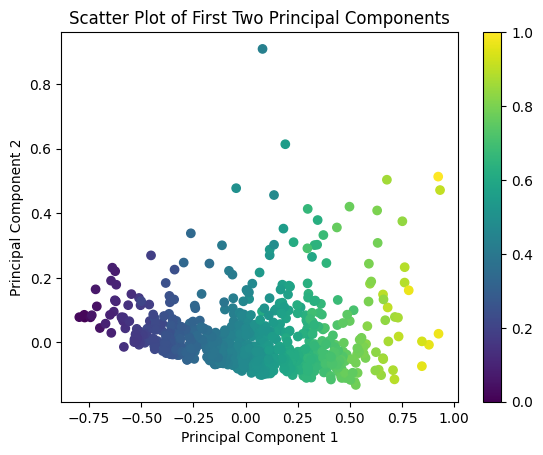

In [7]:
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

# Separate features and target variable
X = X_train_transformed.drop(['Close'], axis=1)
y = X_train_transformed['Close']

# Create PCA instance and fit to the data
pca = PCA(n_components=4)
principal_components = pca.fit_transform(X)

# Plot a scatter plot of the first two principal components
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=y, cmap='viridis')
plt.colorbar()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of First Two Principal Components')

# Calculate R-squared and MSE
y_pred = pca.inverse_transform(principal_components)
r2 = r2_score(y, y_pred[:, 0])
mse = mean_squared_error(y, y_pred[:, 0])

print('R-squared:', r2)
print('MSE:', mse)

plt.show()

If there is a clear separation of the target variable values in the scatter plot, this could indicate that the features are strongly correlated with the target variable and could be good predictors. However, if there is a lot of overlap between the target variable values, it may be more difficult to make accurate predictions based on these features alone.

R-squared is a measure of how well the predicted values match the actual values, with a score of 1 indicating a perfect fit and a score of 0 indicating that the model doesn't explain any of the variance in the target variable. In this case, the R-squared score of 0.988 indicates that the model explains 98.8% of the variance in the target variable, which is a very good fit.

Mean squared error (MSE) is a measure of the average squared difference between the predicted values and the actual values. In this case, the MSE of 0.000479325 means that, on average, the predicted values are 0.000479325 away from the actual values. Since this value is relatively small, it suggests that the model is making accurate predictions.

### Autocorrelation Strength

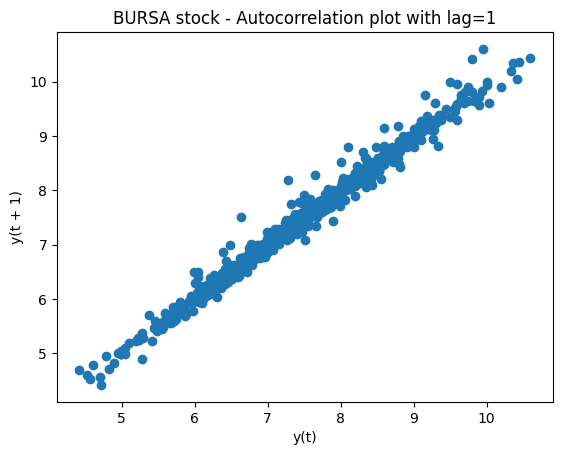

In [11]:
from pandas.plotting import lag_plot
plt.figure()
lag_plot(df["Close"], lag=1)
plt.title("BURSA stock - Autocorrelation plot with lag=1")
plt.show()

Strong positive autocorrelation

## Plot Data

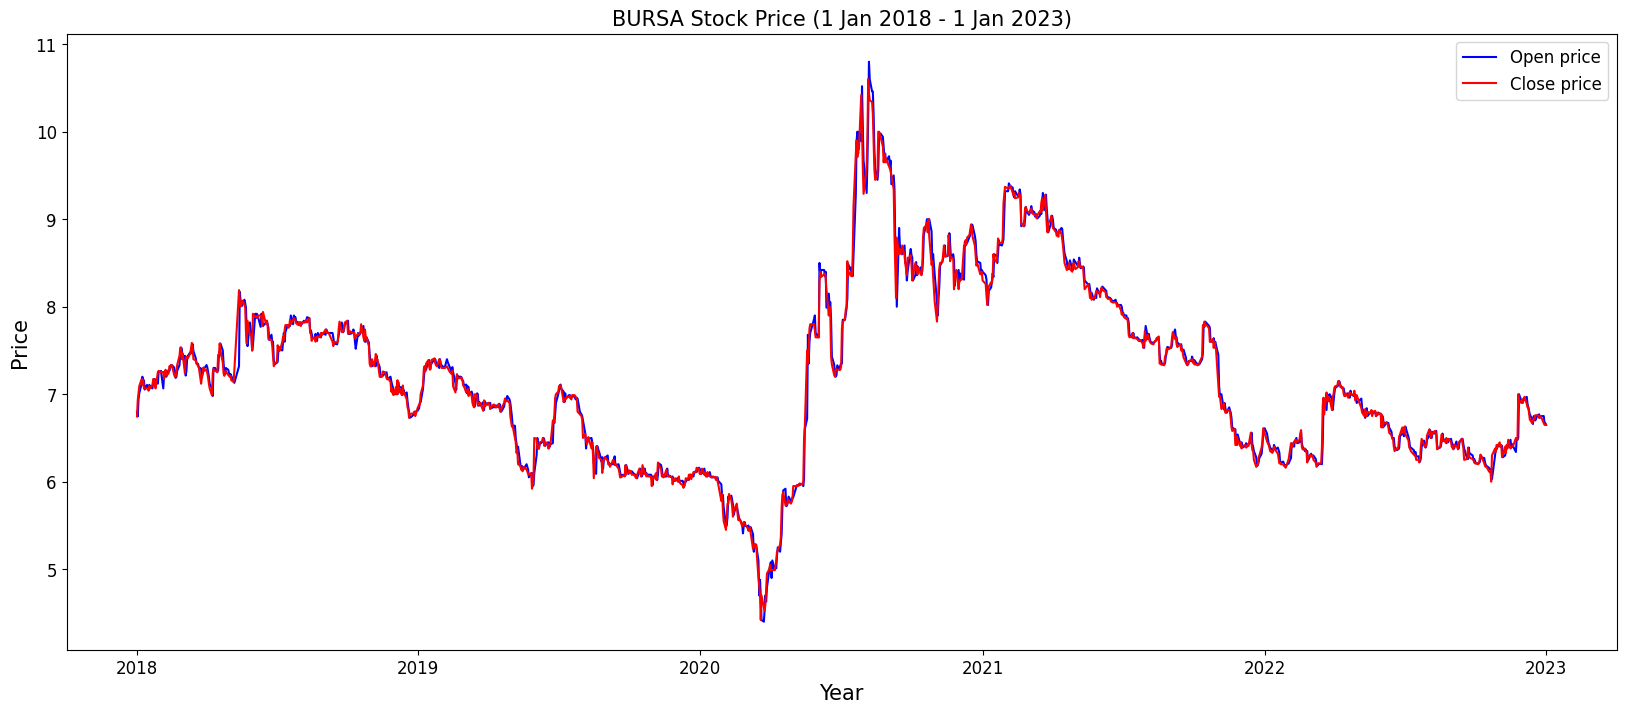

In [12]:
# Create a figure and an axis object
fig, ax = plt.subplots(figsize=(20,8))

# Plot the data
ax.plot(df['Open'], c='b', label='Open price')
ax.plot(df['Close'], c='r', label='Close price')

# Define labels
labels = ['2018', '2019', '2020', '2021', '2022', '2023']

# Set the x-axis ticks and labels
ax.set_xticks(df.index[[0, 243, 489, 736, 981, -1]])
ax.set_xticklabels(labels)

# Set the axis labels and the title
ax.set_xlabel('Year', fontsize = 15)
ax.set_ylabel('Price', fontsize = 15)
ax.set_title('BURSA Stock Price (1 Jan 2018 - 1 Jan 2023)', fontsize = 15)

# Add a legend
plt.legend(fontsize = 12)

# Display the plot
plt.tick_params(labelsize = 12)
plt.show()

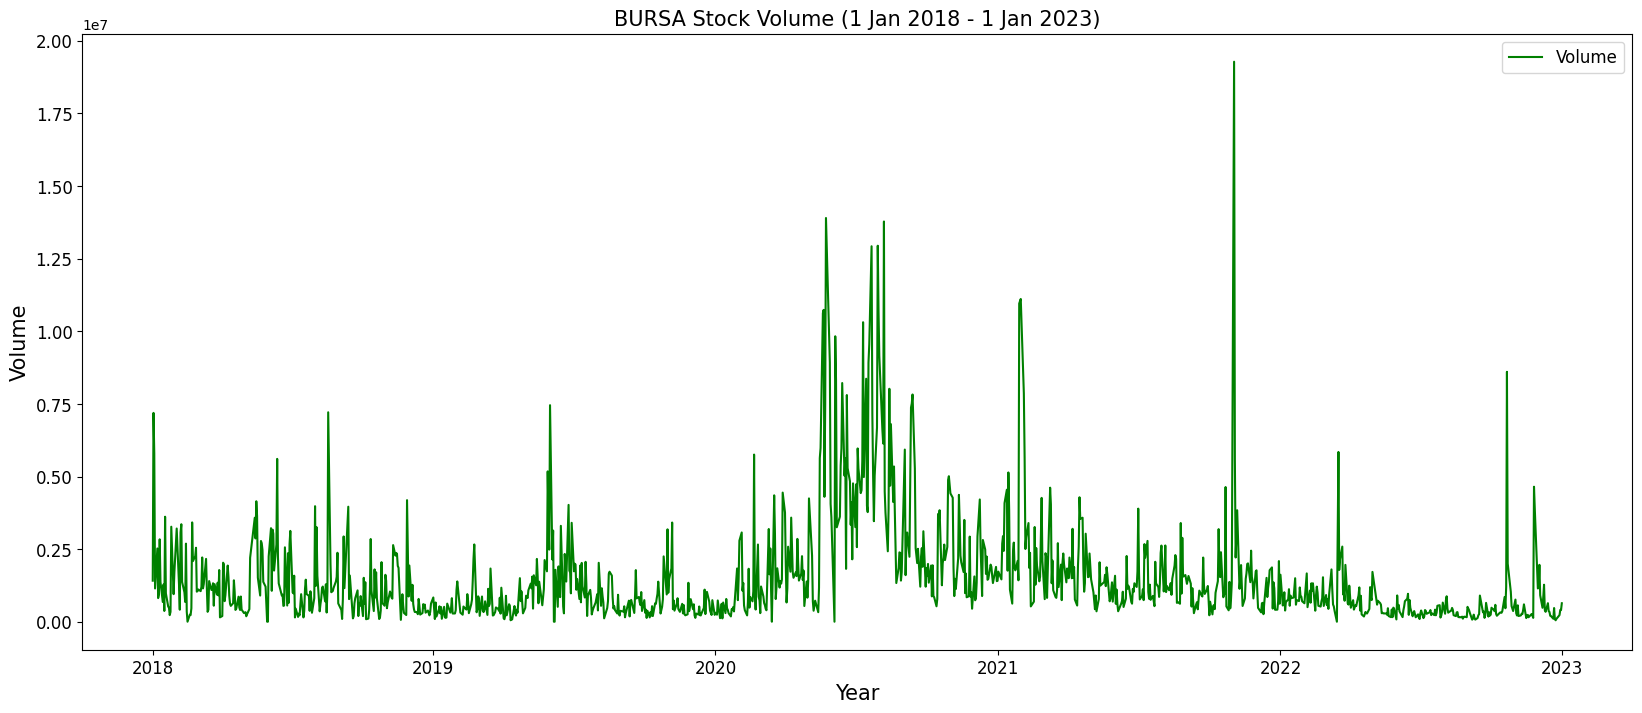

In [13]:
# Plot the Volume
fig,ax = plt.subplots(figsize = (20,8))

ax.plot(df['Volume'],c = 'g',label = 'Volume')

# Define labels
labels = ['2018', '2019', '2020', '2021', '2022', '2023']

# Set the x-axis ticks and labels
ax.set_xticks(df.index[[0, 243, 489, 736, 981, -1]])
ax.set_xticklabels(labels)

# Set the axis labels and the title
ax.set_xlabel('Year', fontsize = 15)
ax.set_ylabel('Volume', fontsize = 15)
ax.set_title('BURSA Stock Volume (1 Jan 2018 - 1 Jan 2023)', fontsize = 15)

plt.tick_params(labelsize = 12)
plt.legend(fontsize = 12)
plt.show()

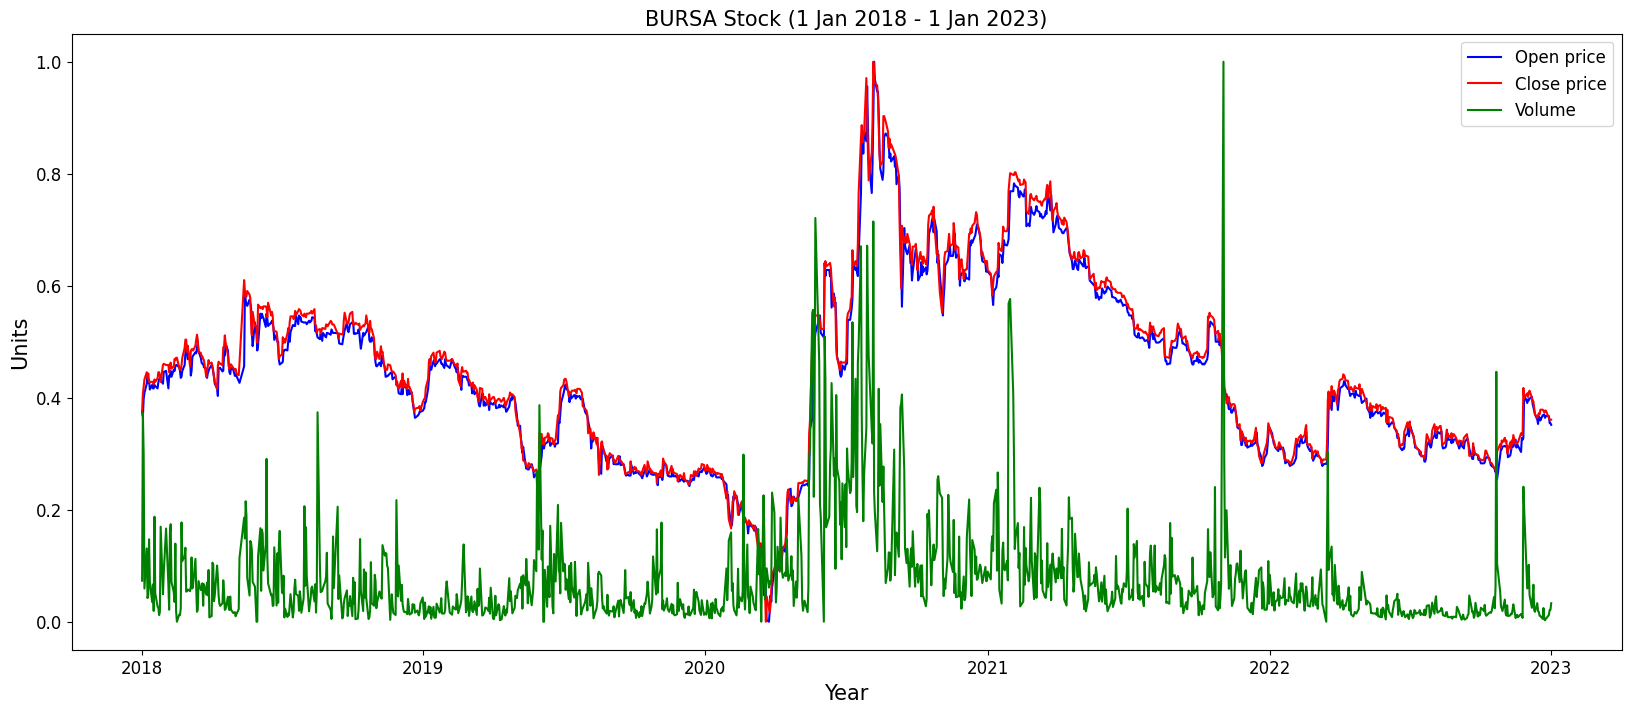

In [14]:
# Plot the points
fig,ax = plt.subplots(figsize = (20,8))

ax.plot(df_transformed['Open'], c='b', label='Open price')
ax.plot(df_transformed['Close'], c='r', label='Close price')
ax.plot(df_transformed['Volume'],c ='g',label = 'Volume')

# Define labels
labels = ['2018', '2019', '2020', '2021', '2022', '2023']

# Set the x-axis ticks and labels
ax.set_xticks(df.index[[0, 243, 489, 736, 981, -1]])
ax.set_xticklabels(labels)

# Set the axis labels and the title
ax.set_xlabel('Year', fontsize = 15)
ax.set_ylabel('Units', fontsize = 15)
ax.set_title('BURSA Stock (1 Jan 2018 - 1 Jan 2023)', fontsize = 15)

plt.tick_params(labelsize = 12)
plt.legend(fontsize = 12)
plt.show()

## LSTM Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Define the model architecture
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train_transformed.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Reshape the data to 3D arrays for LSTM input
X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

y_train = y_train.values.reshape((y_train.shape[0], 1))
y_test = y_test.values.reshape((y_test.shape[0], 1))

print(X_train_transformed.shape)
print(y_train_transformed.shape)

# Fit the model on the training set
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)


(980, 5)
(980, 1)


This model has three LSTM layers, with 128, 64, and 32 units respectively. There are also dropout layers added after each LSTM layer with a dropout rate of 0.2 to prevent overfitting. The last layer is a dense layer with one unit.

## Model Evaluation

In [16]:
from sklearn.metrics import accuracy_score, mean_squared_error

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy score (if it is a classification problem)
# Convert predicted probabilities to class labels
y_pred_classes = np.round(y_pred).astype(int)
y_test_classes = np.round(y_test).astype(int)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
print("Accuracy Score:", accuracy)

# Calculate mean squared error (MSE) and root mean squared error (RMSE)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

8/8 [==============================] - 1s 4ms/step
Accuracy Score: 0.9673469387755103
Mean Squared Error: 0.0030888758909887516
Root Mean Squared Error: 0.055577656400650356


## Prediction

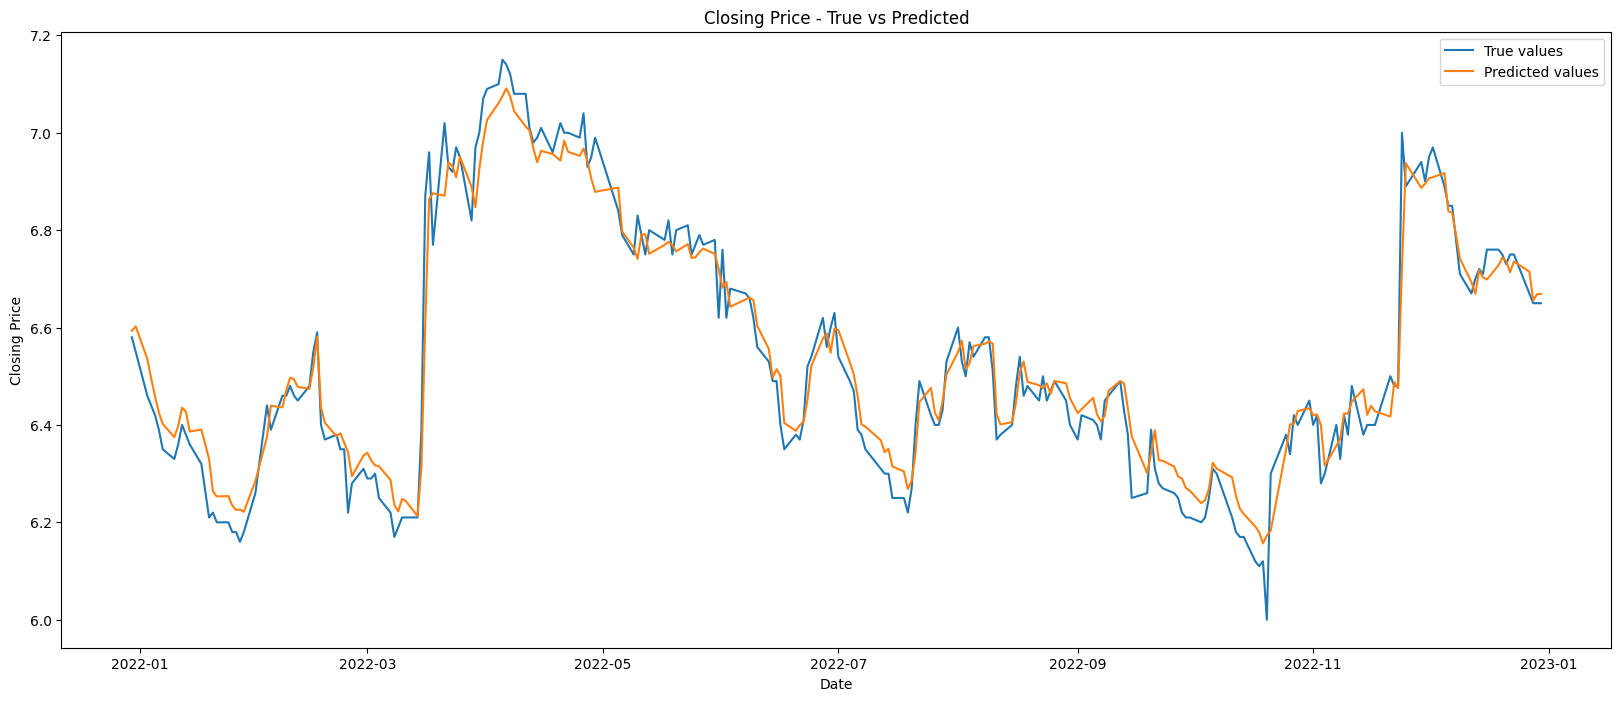

In [17]:
import matplotlib.pyplot as plt

# Plot the predicted values against the true values
plt.figure(figsize=(20, 8))
plt.plot(y_test_transformed.index, y_test, label='True values')
plt.plot(y_test_transformed.index, y_pred, label='Predicted values')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Closing Price - True vs Predicted')
plt.legend()
plt.show()

## Export Values using LSTM Model

In [19]:
import pandas as pd

# Combine y_train and y_test to create y_full_pred
# y_full_pred = pd.concat([pd.Series(y_train.squeeze()), pd.Series(y_test.squeeze())])
y_full_pred = y

X_full = df[features]

# Predict on the entire dataset
X_full = X_full.values.reshape((X_full.shape[0], X_full.shape[1], 1))
y_full_pred = model.predict(X_full)

# Convert y_full_pred to a DataFrame with the same index as the original DataFrame
y_full_pred_df = pd.DataFrame(y_full_pred, columns=['Close'], index=df.index)

# Create a DataFrame with Date, True Values, and Predicted Values
predicted_df = pd.DataFrame({'Date': df.index, 'True Values': df['Close'], 'Predicted Values': y_full_pred_df['Close']})

# Ensure 'Date' column is in datetime format
predicted_df['Date'] = pd.to_datetime(predicted_df['Date'])

# Reset the index to avoid ambiguity
predicted_df.reset_index(drop=True, inplace=True)

# Sort the DataFrame based on the 'Date' column in ascending order
predicted_df.sort_values(by='Date', inplace=True)

# Export the DataFrame to a CSV file
predicted_df.to_csv('predicted_values_with_dates.csv', index=False)

39/39 [==============================] - 0s 3ms/step
